In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import oat_python as oat
import os

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [27]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001
max_dim = 1
years_grid = np.linspace(0, 1, 100)
inv_counts_grid = np.linspace(0, 1, 40)

def dataprocess(df):
    df = df[df['relevance_mean'] >= MIN_RELEVANCE]
    df = df[df['year'] >= MIN_YEAR]
    num_articles = df['article_id'].nunique()
    concept_freq = df.groupby('concept').transform('size') / num_articles
    df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]
    df = df[['article_id', 'concept', 'year']]

    return(df)

def conceptprocess(df):
    concepts = (
            df
                .sort_values('year')
                .groupby('concept')
                .agg(
                    year=('year', 'min'),
                    count=('article_id', 'nunique')
                )
                .reset_index()
        )

    concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    concepts['inv_count'] = 1 / concepts['count']
    return(concepts)

def edgeprocess(df):
    edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])
    edges = edges[edges['concept_source'] < edges['concept_target']]
    edges = edges.groupby(['concept_source', 'concept_target']).agg(
            year=('year', 'min'),
            count=('article_id', 'nunique')
        ).reset_index()

    edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    edges['inv_count'] = 1 / edges['count']
    return(edges)

def graphprocess(concepts,edges):
    G = nx.Graph()

    # add the nodes
    G.add_nodes_from([(c, {'norm_year': ny, 'inv_count': ic}) for c, ny, ic in zip(concepts['concept'], concepts['norm_year'], concepts['inv_count'])])

    # add the edges
    G.add_edges_from([(u, v, {'norm_year': ny, 'inv_count': ic}) for u, v, ny, ic in zip(edges['concept_source'], edges['concept_target'], edges['norm_year'], edges['inv_count'])])
    
    return(G)

def processbetticurve(G):
    adj_year = nx.adjacency_matrix(G, weight='norm_year')
    adj_year.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
    adj_inv_count = nx.adjacency_matrix(G, weight='inv_count')
    adj_inv_count.setdiag([d['inv_count'] for _, d in G.nodes(data=True)])
    adj_year = adj_year.sorted_indices()
    betti_curves = np.empty((len(years_grid), len(inv_counts_grid), max_dim + 1))

    return betti_curves

def runcrocker(G, years_grid, inv_counts_grid):
    adj_year = nx.adjacency_matrix(G, weight='norm_year')
    adj_year.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
    adj_inv_count = nx.adjacency_matrix(G, weight='inv_count')
    adj_inv_count.setdiag([d['inv_count'] for _, d in G.nodes(data=True)])
    adj_year = adj_year.sorted_indices()

    betti_curves = np.empty((len(years_grid), len(inv_counts_grid), max_dim + 1))

    for i, c in enumerate(inv_counts_grid):
        # zero out things not included
        c_adj = adj_year.copy()
        c_adj[adj_inv_count > c] = 0
        c_adj.eliminate_zeros()

        c_adj.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
        c_adj = c_adj.sorted_indices()

        if c_adj.nnz == 0 or c_adj.shape[0] == 0:
            for d in range(max_dim + 1):
                betti_curves[:, i, d] = 0
            continue

        try:
            factored = oat.rust.FactoredBoundaryMatrixVr(c_adj, max_dim)
            homology = factored.homology(False, False)

            for d in range(max_dim + 1):
                dim_homology = homology[homology['dimension'] == d]
                betti_curves[:, i, d] = ((dim_homology['birth'].values <= years_grid[:, None]) &
                                        (dim_homology['death'].values > years_grid[:, None])).sum(axis=1)
        except Exception as e:
            print(f"OAT error at inv_count={c:.3f}: {e}")
            for d in range(max_dim + 1):
                betti_curves[:, i, d] = 0

    return betti_curves

def mainfunc(df, years_grid, inv_counts_grid):
    df = dataprocess(df)
    concepts = conceptprocess(df)
    edges = edgeprocess(df)
    G = graphprocess(concepts, edges)
    betti_curves = runcrocker(G, years_grid, inv_counts_grid)
    return betti_curves

In [18]:
data_dir = "cache2"
files = sorted(f for f in os.listdir(data_dir) if f.endswith(".csv"))

In [19]:
#fields = pd.read_csv("files.csv")
X_vecs = []
field_names = []

In [3]:
os.makedirs("cache", exist_ok=True)
def download_or_cache(link, filename):
    if os.path.exists(filename):
        return pd.read_csv(filename)
    else:
        df = pd.read_csv(link, compression='gzip')
        df.to_csv(filename, index=False)
        return df

In [5]:
download_or_cache('https://www.dropbox.com/scl/fi/kp2835e2wbw2d8ucngx5d/concepts_Applied-Mathematics_102.csv.gz?rlkey=27o5dh9piahunpyzmm34m0498&st=o0gish0n&dl=1', f"cache/{'Applied Mathematics'}.csv")

,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1011927506,2001,abi raising standards scheme,0.0,1,0,1,1
1,pub.1091536887,1988,attu conventional arm control forum,0.0,1,0,1,1
2,pub.1127413625,1997,av 8 harrier,0.0,1,0,1,1
3,pub.1021705670,2010,advertisement game strategy,0.0,1,0,1,1
4,pub.1058195248,1984,aramovich aleksandryan,0.0,1,0,1,1
...,...,...,...,...,...,...,...,...
26399751,pub.1015682740,2008,’s ψ11 summation formula,0.0,1,29,1,1
26399752,pub.1140295407,2021,’ ω transform,0.0,1,4,1,1
26399753,pub.1039011473,2010,’ ϵ variational principle,0.0,1,32,1,1
26399754,pub.1128915375,2020,′ | z | 2 d,0.0,1,16,1,1


In [ ]:
for _, row in subset.iterrows():
    field = row['field']
    link = row['link'].strip()
    
    try:
        df = download_or_cache(link, f"cache/{field}.csv")
        betti_curves = mainfunc(df)
        vec = betti_curves.flatten()
        X_vecs.append(vec)
        field_names.append(field)

    except Exception as e:
        print(f"Failed on {field}: {e}")
        continue

X = np.array(X_vecs)
print(f"Finished vectorization. Shape = {X.shape}")

In [28]:
for fname in files:
    path = os.path.join(data_dir, fname)
    field = fname.replace(".csv", "").replace("_", " ")

    try:
        df = pd.read_csv(path)
        betti_curves = mainfunc(df, years_grid, inv_counts_grid)
        if betti_curves.shape != (100, 40, 2):
            print(f"{field} skipped: shape {betti_curves.shape}")
            continue

        vec = betti_curves.flatten()
        X_vecs.append(vec)
        field_names.append(field)
        print(f"{field} vectorized.")

    except Exception as e:
        print(f"Failed on {field}: {e}")

X = np.array(X_vecs)
print("All fields processed. Final shape:", X.shape)

Classical Physics vectorized.
Computer Hardware vectorized.
Human Geography vectorized.
Mathematical Physics vectorized.
Philosophy vectorized.
Quantum Physics vectorized.
Zoology vectorized.
All fields processed. Final shape: (11, 8000)


In [33]:
X = np.array(X_vecs)
fields = np.array(field_names)
_, unique_indices = np.unique(fields, return_index=True)
X_unique = X[unique_indices]
fields_unique = fields[unique_indices]

In [34]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_unique)
cluster_df = pd.DataFrame({
    "field": fields_unique,
    "cluster": labels
}).sort_values("cluster")
print(cluster_df)

                  field  cluster
2       Human Geography        0
5       Quantum Physics        0
6               Zoology        0
0     Classical Physics        1
1     Computer Hardware        1
3  Mathematical Physics        1
4            Philosophy        2


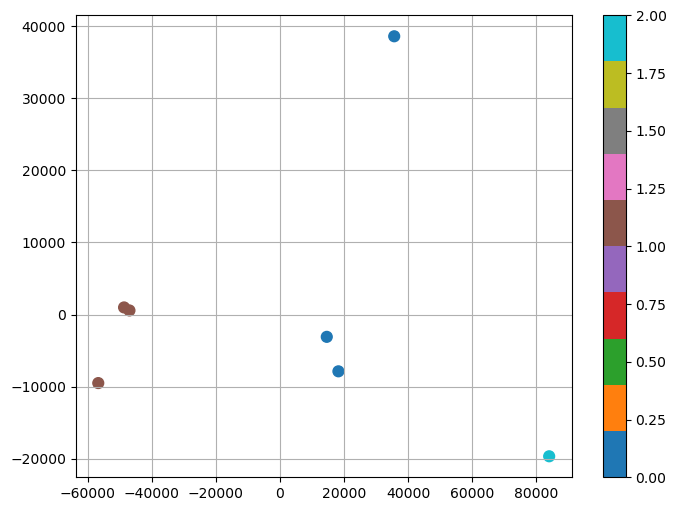

In [36]:
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_unique)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=60)
plt.colorbar(scatter)
plt.grid(True)
plt.show()

In [37]:
cluster_0_fields = cluster_df[cluster_df['cluster'] == 0]['field'].to_list()
print(len(cluster_0_fields))
print(cluster_0_fields)

3
['Human Geography', 'Quantum Physics', 'Zoology']


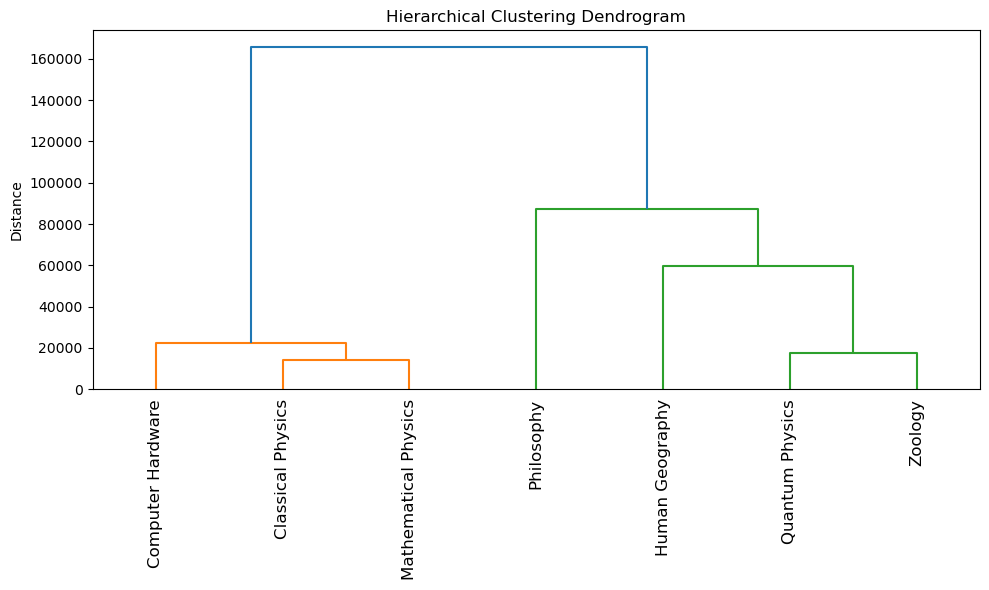

In [40]:
Z = linkage(X_unique, method='ward', metric='euclidean')

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=fields_unique, leaf_rotation=90)
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.tight_layout()
plt.show()

In [42]:
hier_labels = fcluster(Z, t=3, criterion='maxclust')

hier_cluster_df = pd.DataFrame({
    "field": fields_unique,
    "cluster": hier_labels
}).sort_values("cluster")

print("\nHierarchical Clustering Results:")
print(hier_cluster_df)


Hierarchical Clustering Results:
                  field  cluster
0     Classical Physics        1
1     Computer Hardware        1
3  Mathematical Physics        1
2       Human Geography        2
5       Quantum Physics        2
6               Zoology        2
4            Philosophy        3


In [43]:
print("\nComparison of K-means and Hierarchical Clustering:")
comparison_df = cluster_df.copy()
comparison_df["hier_cluster"] = hier_cluster_df["cluster"]
print(comparison_df)


Comparison of K-means and Hierarchical Clustering:
                  field  cluster  hier_cluster
2       Human Geography        0             2
5       Quantum Physics        0             2
6               Zoology        0             2
0     Classical Physics        1             1
1     Computer Hardware        1             1
3  Mathematical Physics        1             1
4            Philosophy        2             3
